
Original Peak Coordinates:
Peak 1: (2245, 1436)
Peak 2: (1573, 1633)
Peak 3: (2723, 1846)
Peak 4: (1373, 2231)
Peak 5: (2523, 2463)
Peak 6: (1856, 2633)
Primary box 1 at (2220, 1411) intensity sum: 4110319161202487.5
Adjacent box 1 at (2286, 1432) intensity sum: 1723452190516147.5
Intensity difference 1: 2386866970686340.0
Primary box 2 at (1548, 1608) intensity sum: 2985317368417496.0
Adjacent box 2 at (1597, 1558) intensity sum: 1648059308986238.0
Intensity difference 2: 1337258059431258.0
Primary box 3 at (2698, 1821) intensity sum: 4971311028295150.0
Adjacent box 3 at (2718, 1890) intensity sum: 1583256980286631.5
Intensity difference 3: 3388054048008518.5
Primary box 4 at (1348, 2206) intensity sum: 5245778532481639.0
Adjacent box 4 at (1335, 2132) intensity sum: 1561679700738400.8
Intensity difference 4: 3684098831743238.0
Primary box 5 at (2498, 2438) intensity sum: 3008094396567017.5
Adjacent box 5 at (2455, 2483) intensity sum: 1690811419921337.2
Intensity difference 5: 13172

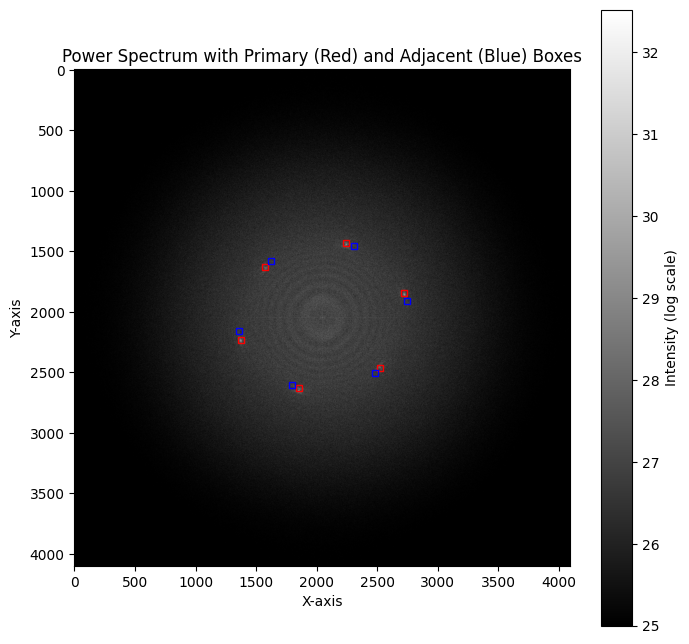

2406341560200362.0

In [29]:
import mrcfile
import numpy as np
import matplotlib.pyplot as plt

# === 1. Power Spectrum Calculation ===
def power_spectrum(image):
    fft_image = np.fft.fftshift(np.fft.fft2(image))
    power_spec = np.abs(fft_image) ** 2
    return power_spec

# === 2. Peak Detection with Thresholding & Distance Filtering ===
def find_peaks_with_threshold(power_spec, num_peaks=6, min_distance=500, threshold_factor=0.1):
    height, width = power_spec.shape
    center_x, center_y = width // 2, height // 2

    mask = np.ones_like(power_spec)
    mask[center_y-300:center_y+300, center_x-300:center_x+300] = 0  # Exclude center
    masked_power_spec = power_spec * mask

    max_intensity = np.max(masked_power_spec)
    threshold = threshold_factor * max_intensity
    threshold_mask = masked_power_spec >= threshold
    peak_coords = np.argwhere(threshold_mask)

    final_peaks = []
    for y, x in peak_coords:
        is_too_close = any(np.hypot(x - px, y - py) < min_distance for py, px in final_peaks)
        if not is_too_close:
            final_peaks.append((y, x))
        if len(final_peaks) >= num_peaks:
            break

    return final_peaks  # (row, col)

# === 3. Get Adjacent Point on Same Radius ===
def get_adjacent_point_on_same_radius(coord, center, angle_offset_deg=6):
    y, x = coord  # row, col
    cy, cx = center
    dx = x - cx
    dy = y - cy
    r = np.sqrt(dx**2 + dy**2)
    theta = np.arctan2(dy, dx)
    theta_adj = theta + np.deg2rad(angle_offset_deg)
    adj_x = int(round(cx + r * np.cos(theta_adj)))
    adj_y = int(round(cy + r * np.sin(theta_adj)))
    return (x, y), (adj_x, adj_y)  # Return as (x, y)

# === 4. Plot Power Spectrum with Primary and Adjacent Boxes ===
def plot_power_spectrum_with_boxes(power_spec, coordinates):
    plt.figure(figsize=(8, 8))
    plt.imshow(np.log(power_spec), cmap='gray', vmin=25)

    box_size = 50
    intensity_differences = []

    for i, (primary, adjacent) in enumerate(coordinates):
        x, y = primary
        x2, y2 = adjacent

        rect1 = plt.Rectangle((x, y), box_size, box_size, linewidth=1, edgecolor='red', facecolor='none')
        plt.gca().add_patch(rect1)
        box1 = np.sum(power_spec[y:y+box_size, x:x+box_size])
        print(f'Primary box {i+1} at ({x}, {y}) intensity sum: {box1}')

        rect2 = plt.Rectangle((x2, y2), box_size, box_size, linewidth=1, edgecolor='blue', facecolor='none')
        plt.gca().add_patch(rect2)
        box2 = np.sum(power_spec[y2:y2+box_size, x2:x2+box_size])
        print(f'Adjacent box {i+1} at ({x2}, {y2}) intensity sum: {box2}')

        diff = box1 - box2
        intensity_differences.append(diff)
        print(f'Intensity difference {i+1}: {diff}')

    mean_diff = np.mean(intensity_differences)
    print(f'\nMean intensity difference: {mean_diff}')

    plt.title('Power Spectrum with Primary (Red) and Adjacent (Blue) Boxes')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.colorbar(label='Intensity (log scale)')
    plt.show()

    return mean_diff

# === 5. Load MRC Image ===
with mrcfile.open('/mnt/em_data/vishal/data/04042025_paraffin_normal/auto/0000000666/image_ctfcor.mrc') as mrc:
    image = mrc.data

# === 6. Compute Power Spectrum ===
power_spec = power_spectrum(image)

# === 7. Find Peaks ===
peak_coords = find_peaks_with_threshold(power_spec, num_peaks=6, min_distance=500, threshold_factor=0.1)
print("\nOriginal Peak Coordinates:")
for i, (y, x) in enumerate(peak_coords):
    print(f"Peak {i+1}: ({x}, {y})")

# === 8. Offset Coordinates for Primary Boxes ===
modified_coords = [(max(0, y - 25), max(0, x - 25)) for y, x in peak_coords]

# === 9. Compute Adjacent Points on Same Radius ===
center = (image.shape[0] // 2, image.shape[1] // 2)
box_coordinates = [get_adjacent_point_on_same_radius(coord, center, angle_offset_deg=6) for coord in modified_coords]

# === 10. Plot and Compute Differences ===
plot_power_spectrum_with_boxes(power_spec, box_coordinates)


[1] /mnt/em_data/vishal/data/04042025_paraffin_normal/auto/0000000666/image_ctfcor.mrc - Avg Intensity Difference: 2406341560200362.00
[2] /mnt/em_data/vishal/data/04042025_paraffin_normal/auto/0000000667/image_ctfcor.mrc - Avg Intensity Difference: 2197106959096285.00
[3] /mnt/em_data/vishal/data/04042025_paraffin_normal/auto/0000000668/image_ctfcor.mrc - Avg Intensity Difference: 1454276794229150.00
[4] /mnt/em_data/vishal/data/04042025_paraffin_normal/auto/0000000669/image_ctfcor.mrc - Avg Intensity Difference: 938715139214391.00
[5] /mnt/em_data/vishal/data/04042025_paraffin_normal/auto/0000000670/image_ctfcor.mrc - Avg Intensity Difference: 675843111476700.62
[6] /mnt/em_data/vishal/data/04042025_paraffin_normal/auto/0000000671/image_ctfcor.mrc - Avg Intensity Difference: 396320099373791.31
[7] /mnt/em_data/vishal/data/04042025_paraffin_normal/auto/0000000672/image_ctfcor.mrc - Avg Intensity Difference: 210059999099985.78
[8] /mnt/em_data/vishal/data/04042025_paraffin_normal/auto/

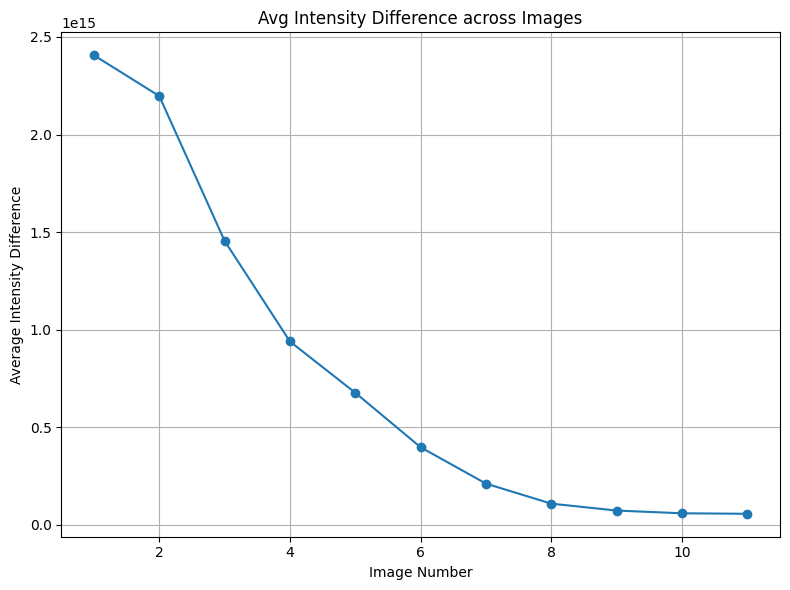

In [30]:
import mrcfile
import numpy as np
import matplotlib.pyplot as plt

# === Compute Power Spectrum ===
def power_spectrum(image):
    fft_image = np.fft.fftshift(np.fft.fft2(image))
    power_spec = np.abs(fft_image) ** 2
    return power_spec

# === Plot and Measure Intensity Differences ===
def plot_power_spectrum(power_spec, coordinates):
    box_size = 50
    intensity_differences = []

    for i, (primary, adjacent) in enumerate(coordinates):
        x1, y1 = primary
        x2, y2 = adjacent

        box1 = power_spec[y1:y1 + box_size, x1:x1 + box_size]
        box2 = power_spec[y2:y2 + box_size, x2:x2 + box_size]

        intensity_diff = np.sum(box1) - np.sum(box2)
        intensity_differences.append(intensity_diff)

    mean_intensity_diff = np.mean(intensity_differences)
    return mean_intensity_diff

# === Process Multiple MRC Files ===
def process_multiple_mrc_files(file_paths, coordinates):
    avg_differences = []

    for idx, file_path in enumerate(file_paths):
        with mrcfile.open(file_path) as mrc:
            image = mrc.data

        power_spec = power_spectrum(image)
        mean_diff = plot_power_spectrum(power_spec, coordinates)
        avg_differences.append(mean_diff)

        print(f'[{idx + 1}] {file_path} - Avg Intensity Difference: {mean_diff:.2f}')

    return avg_differences

# === Plot Average Intensity Differences ===
def plot_avg_intensity_difference(avg_differences):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(avg_differences) + 1), avg_differences, marker='o')
    plt.xlabel('Image Number')
    plt.ylabel('Average Intensity Difference')
    plt.title('Avg Intensity Difference across Images')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === File Paths ===
file_paths = [
    '/mnt/em_data/vishal/data/04042025_paraffin_normal/auto/0000000666/image_ctfcor.mrc',
    '/mnt/em_data/vishal/data/04042025_paraffin_normal/auto/0000000667/image_ctfcor.mrc',
    '/mnt/em_data/vishal/data/04042025_paraffin_normal/auto/0000000668/image_ctfcor.mrc',
    '/mnt/em_data/vishal/data/04042025_paraffin_normal/auto/0000000669/image_ctfcor.mrc',
    '/mnt/em_data/vishal/data/04042025_paraffin_normal/auto/0000000670/image_ctfcor.mrc',
    '/mnt/em_data/vishal/data/04042025_paraffin_normal/auto/0000000671/image_ctfcor.mrc',
    '/mnt/em_data/vishal/data/04042025_paraffin_normal/auto/0000000672/image_ctfcor.mrc',
    '/mnt/em_data/vishal/data/04042025_paraffin_normal/auto/0000000673/image_ctfcor.mrc',
    '/mnt/em_data/vishal/data/04042025_paraffin_normal/auto/0000000674/image_ctfcor.mrc',
    '/mnt/em_data/vishal/data/04042025_paraffin_normal/auto/0000000675/image_ctfcor.mrc',
    '/mnt/em_data/vishal/data/04042025_paraffin_normal/auto/0000000676/image_ctfcor.mrc',
]

# === Run Processing ===
avg_intensity_differences = process_multiple_mrc_files(file_paths, coordinates)

# === Plot Results ===
plot_avg_intensity_difference(avg_intensity_differences)


In [17]:
print(np.shape(avg_intensity_differences))
np.savetxt('/home/vikumar/analysis_data/04042025_paraffin_normal/2.txt', avg_intensity_differences, delimiter=' ', fmt="%.2f")

(11,)
